# Install Torch Geometric

In [ ]:
!pip install torch_geometric
!pip install torch_sparse
!pip install torch_scatter
!pip install pytorch_lightning

# Imports

In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path
from torch_geometric.data import Data, Batch
import torch
import torch.nn.functional as F

from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from typing import Tuple, Dict, List

import networkx as nx


# Plotting ARC sample

In [2]:
def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 4, figsize=(15,15))
    axs[0].imshow(task['train'][0]['input'], cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Train Input')
    axs[1].imshow(task['train'][0]['output'], cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Train Output')
    axs[2].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Test Input')
    axs[3].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
    axs[3].axis('off')
    axs[3].set_title('Test Output')
    plt.tight_layout()
    plt.show()
    
def plot_task_full(task):
    """
    Plots all train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    lg_train = len(task['train'])
    lg_test = len(task['test'])
    fig, axs = plt.subplots(lg_train, 2, figsize=(10,10))
    for i in range(lg_train):
        axs[i][0].imshow(task['train'][i]['input'], cmap=cmap, norm=norm)
        axs[i][0].axis('off')
        axs[i][0].set_title('Train Input')
        axs[i][1].imshow(task['train'][i]['output'], cmap=cmap, norm=norm)
        axs[i][1].axis('off')
        axs[i][1].set_title('Train Output')
    fig2, axs2 = plt.subplots(lg_test, 2, figsize=(10,10))
    for i in range(lg_test):
        axs2[0].imshow(task['test'][i]['input'], cmap=cmap, norm=norm)
        axs2[0].axis('off')
        axs2[0].set_title('Test Input')
        axs2[1].imshow(task['test'][i]['output'], cmap=cmap, norm=norm)
        axs2[1].axis('off')
        axs2[1].set_title('Test Output')
    plt.tight_layout()
    plt.show()

In [3]:
for dirname, _, filenames in os.walk('kaggle/input'):
    print(dirname)

kaggle/input
kaggle/input/abstraction-and-reasoning-challenge
kaggle/input/abstraction-and-reasoning-challenge/training
kaggle/input/abstraction-and-reasoning-challenge/evaluation
kaggle/input/abstraction-and-reasoning-challenge/test
kaggle/input/abstraction-and-reasoning-challenge/.ipynb_checkpoints


In [4]:
data_path = Path('kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [5]:
training_tasks = sorted(os.listdir(training_path))
print(training_tasks[:3])

['007bbfb7.json', '00d62c1b.json', '017c7c7b.json']


In [6]:
task_file = str(training_path / '007bbfb7.json')

with open(task_file, 'r') as f:
    task = json.load(f)

print(task.keys())

dict_keys(['test', 'train'])


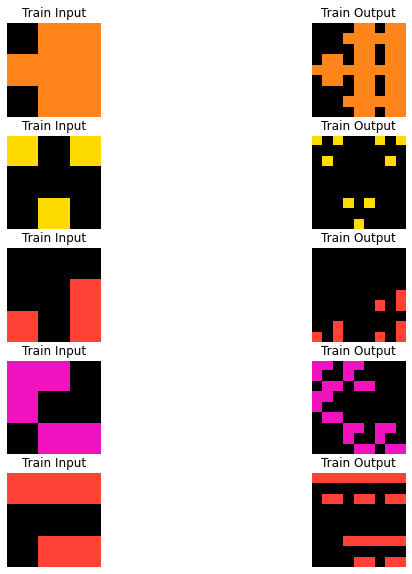

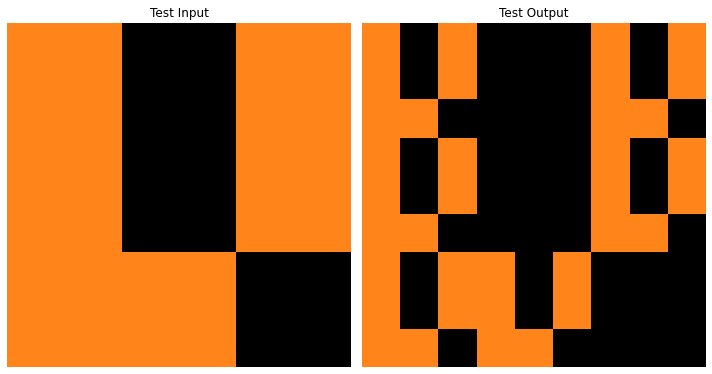

In [10]:
plot_task_full(task)

In [13]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000888888888|00000800080808|...
00dbd492_0  |00000000000222220000|02222222220200020000|020...
03560426_0  |0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002220...

In [14]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [15]:
example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
display(example_grid)
print(flattener(example_grid))

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

|123|456|789|


In [ ]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    # skipping over the training examples, since this will be naive predictions
    # we will use the test input grid as the base, and make some modifications
    data = task['test'][pair_id]['input'] # test pair input
    # for the first guess, predict that output is unchanged
    pred_1 = flattener(data)
    # for the second guess, change all 0s to 5s
    data = [[5 if i==0 else i for i in j] for j in data]
    pred_2 = flattener(data)
    # for the last gues, change everything to 0
    data = [[0 for i in j] for j in data]
    pred_3 = flattener(data)
    # concatenate and add to the submission output
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission.csv')

# Convert ARC sample to Geometric Graph

In [7]:
# To refactor
# Dumb code written stupidly to be sure not to miss any case for now
def sample_to_graph(sample):
    height = len(sample)
    width = len(sample[0])
    data_x = torch.tensor(sample, dtype=torch.float)
    data_x = data_x.flatten().unsqueeze(dim=1).contiguous()
    edge_index=[]
    pos = []
    for y in range(height-1, -1, -1):
        for x in range(width):
            local_edges = []
            pos.append([x, y])
            x0 = x - 1
            y0 = y - 1
            x1 = x + 1
            y1 = y + 1
            pt = x + width * y
            if x0 >= 0:
                local_edges.append([x0 + width * y, pt])
                if y0 >= 0:
                    local_edges.append([x0 + width * y0, pt])
                if y1 <= height - 1:
                    local_edges.append([x0 + width * y1, pt])
                                                       
            if x1 <= width - 1:
                local_edges.append([x1 + width * y, pt])
                if y0 >= 0:
                    local_edges.append([x1 + width * y0, pt])
                if y1 <= height - 1:
                    local_edges.append([x1 + width * y1, pt])

            if y0 >= 0:
                local_edges.append([x + width * y0, pt])
            if y1 <= height - 1:
                local_edges.append([x + width * y1, pt])
            
            edge_index.extend(local_edges)
                    
    edge_index = torch.tensor(edge_index, dtype=torch.long) #
    pos = torch.tensor(pos, dtype=torch.long)
    data = Data(x=data_x, edge_index=edge_index.t().contiguous(), pos=pos)
    return data

def sample_to_graph_padded(sample, target, pad_value = 0) -> Data:
    target_height = len(target)
    target_width = len(target[0])
    
    height = len(sample)
    width = len(sample[0])
    
    # same size
    if target_height == height and target_width == width:
        return sample_to_graph(sample)
    # rest is padding
    else:
        data_x = torch.tensor(sample, dtype=torch.float)

        diff_height = max(target_height, height) - height
        if diff_height % 2 == 0:
            pad_top = pad_bottom = int(diff_height / 2)
        else:
            pad_top = int(diff_height / 2)
            pad_bottom = pad_top + 1
            
        diff_width = max(target_width, width) - width
        if diff_width % 2 == 0:
            pad_left = pad_right = int(diff_width / 2)
        else:
            pad_left =int(diff_width / 2)
            pad_right = pad_left + 1

        
        data_x = F.pad(data_x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=pad_value)
        data_x = data_x.flatten().unsqueeze(dim=1).contiguous()
        edge_index=[]
        pos = []
        final_height = max(target_height, height)
        final_width = max(target_width, width)
        for y in range(final_height-1, -1, -1):
            for x in range(final_width):
                local_edges = []
                pos.append([x, y])
                x0 = x - 1
                y0 = y - 1
                x1 = x + 1
                y1 = y + 1
                pt = x + final_width * y
                if x0 >= 0:
                    local_edges.append([x0 + final_width * y, pt])
                    if y0 >= 0:
                        local_edges.append([x0 + final_width * y0, pt])
                    if y1 <= final_height - 1:
                        local_edges.append([x0 + final_width * y1, pt])

                if x1 <= final_width - 1:
                    local_edges.append([x1 + final_width * y, pt])
                    if y0 >= 0:
                        local_edges.append([x1 + final_width * y0, pt])
                    if y1 <= final_height - 1:
                        local_edges.append([x1 + final_width * y1, pt])

                if y0 >= 0:
                    local_edges.append([x + final_width * y0, pt])
                if y1 <= final_height - 1:
                    local_edges.append([x + final_width * y1, pt])

                edge_index.extend(local_edges)

        edge_index = torch.tensor(edge_index, dtype=torch.long) #
        pos = torch.tensor(pos, dtype=torch.long)
        data = Data(x=data_x, edge_index=edge_index.t().contiguous(), pos=pos)
        return data

def build_image_edges(final_height: int, final_width: int,
                      start_height: int, start_width: int,
                      end_height: int, end_width: int):
    edge_index=[]
    #final_height = start_height + final_height
    #final_width = start_width + final_width
    for y in range(end_height-1, start_height-1, -1):
        for x in range(start_width, end_width):
            local_edges = []
            x0 = x - 1
            y0 = y - 1
            x1 = x + 1
            y1 = y + 1
            pt = x + final_width * y
            if x0 >= start_width:
                local_edges.append([x0 + final_width * y, pt])
                if y0 >= start_height:
                    local_edges.append([x0 + final_width * y0, pt])
                if y1 <= end_height - 1:
                    local_edges.append([x0 + final_width * y1, pt])

            if x1 <= end_width - 1:
                local_edges.append([x1 + final_width * y, pt])
                if y0 >= start_height:
                    local_edges.append([x1 + final_width * y0, pt])
                if y1 <= end_height - 1:
                    local_edges.append([x1 + final_width * y1, pt])

            if y0 >= start_height:
                local_edges.append([x + final_width * y0, pt])
            if y1 <= end_height - 1:
                local_edges.append([x + final_width * y1, pt])

            edge_index.extend(local_edges)
    edge_index = torch.tensor(edge_index, dtype=torch.long) #
    
    return edge_index
    
def build_image_pos(final_height: int, final_width: int):
    pos = []
    for y in range(final_height-1, -1, -1):
        for x in range(final_width):
            pos.append([x, y])
            
    pos = torch.tensor(pos, dtype=torch.long)
    
    return pos
    
def build_edges_image_to_image(final_height: int, final_width: int):
    edge_index=[]
    for y in range(final_height-1, -1, -1):
        for x in range(final_width):
            edge_index.append([x + 2*final_width * y, x + 2*final_width * y + final_width])
            edge_index.append([x + 2*final_width * y + final_width, x + 2*final_width * y])
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return edge_index
    
def sample_to_graph_merged(sample, target, empty_target: bool=False, pad_value = 10) -> Data:
    target_height = len(target)
    target_width = len(target[0])
    
    height = len(sample)
    width = len(sample[0])
    
    # Pad Sample
    data_x = torch.tensor(sample, dtype=torch.float)
    diff_height = max(target_height, height) - height
    if diff_height % 2 == 0:
        pad_top = pad_bottom = int(diff_height / 2)
    else:
        pad_top = int(diff_height / 2)
        pad_bottom = pad_top + 1

    diff_width = max(target_width, width) - width
    if diff_width % 2 == 0:
        pad_left = pad_right = int(diff_width / 2)
    else:
        pad_left =int(diff_width / 2)
        pad_right = pad_left + 1

    data_x = F.pad(data_x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=pad_value)
    
    # Pad Target
    data_y = torch.tensor(target, dtype=torch.float)
    diff_target_height = max(target_height, height) - target_height
    if diff_target_height % 2 == 0:
        pad_target_top = pad_target_bottom = int(diff_target_height / 2)
    else:
        pad_target_top = int(diff_target_height / 2)
        pad_target_bottom = pad_target_top + 1

    diff_target_width = max(target_width, width) - target_width
    if diff_target_width % 2 == 0:
        pad_target_left = pad_target_right = int(diff_target_width / 2)
    else:
        pad_target_left =int(diff_target_width / 2)
        pad_target_right = pad_target_left + 1
    data_y = F.pad(data_y, pad=(pad_target_left, pad_target_right, pad_target_top, pad_target_bottom), mode='constant', value=pad_value)
    if empty_target:
        data_y = data_y.fill_(pad_value)

    # horizontally cat
    data_full = torch.cat((data_x, data_y), dim=1)
    data_full = data_full.flatten().unsqueeze(dim=1).contiguous()

    final_height = max(target_height, height)
    final_width = max(target_width, width) # twice as we concat horizontally

    edges_index_x = build_image_edges(final_height, 2*final_width, 0, 0, final_height, final_width)
    edges_index_y = build_image_edges(final_height, 2*final_width, 0, final_width, final_height, 2*final_width)
    pos = build_image_pos(final_height, 2*final_width)
    edges_image_to_image = build_edges_image_to_image(final_height, final_width)
    #edges_index = torch.cat((edges_index_x, edges_index_y, edges_image_to_image), dim=0)
    edges_index = torch.cat((edges_index_x, edges_index_y, edges_image_to_image), dim=0)
    #pos = torch.cat((pos_x, pos_y), dim=0)

    data = Data(x=data_full, edge_index=edges_index.t().contiguous(), pos=pos)
    return data
    

# Code copied from master version because the one in v1.4.3 is buggy
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    r"""Converts a :class:`torch_geometric.data.Data` instance to a
    :obj:`networkx.DiGraph` if :attr:`to_undirected` is set to :obj:`True`, or
    an undirected :obj:`networkx.Graph` otherwise.
    Args:
        data (torch_geometric.data.Data): The data object.
        node_attrs (iterable of str, optional): The node attributes to be
            copied. (default: :obj:`None`)
        edge_attrs (iterable of str, optional): The edge attributes to be
            copied. (default: :obj:`None`)
        to_undirected (bool, optional): If set to :obj:`True`, will return a
            a :obj:`networkx.Graph` instead of a :obj:`networkx.DiGraph`. The
            undirected graph will correspond to the upper triangle of the
            corresponding adjacency matrix. (default: :obj:`False`)
        remove_self_loops (bool, optional): If set to :obj:`True`, will not
            include self loops in the resulting graph. (default: :obj:`False`)
    """

    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()

    G.add_nodes_from(range(data.num_nodes))

    values = {}
    for key, item in data:
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]

    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue

        if remove_self_loops and u == v:
            continue

        G.add_edge(u, v)
        for key in edge_attrs if edge_attrs is not None else []:
            G[u][v][key] = values[key][i]
    for key in node_attrs if node_attrs is not None else []:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})

    return G

DEFAULT_CMAP = [
    '#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25',
    #_1 color
    '#FFFFFF'
]

def draw_graph(data: Data, title: str, ax=None, cmap=DEFAULT_CMAP):
    G = to_networkx(data, to_undirected=True, node_attrs=["x", "pos"])
    # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
    #pos = nx.kamada_kawai_layout(nx_G)
    node_labels = nx.get_node_attributes(G, 'x')
    node_pos = nx.get_node_attributes(G, 'pos')
    pos = nx.spring_layout(G, pos=node_pos) #, fixed = fixed_nodes)
    node_labels = { i: int(x) for (i, x) in node_labels.items()}
    nx.draw(G, pos, ax=ax)
    node_pos = { i:i for i, _ in node_pos.items() }
    nx.draw_networkx_nodes(G, pos, node_color=[cmap[i] for i in node_labels.values()], ax=ax)
    nx.draw_networkx_labels(G, pos, labels=node_pos, font_color="w", ax=ax)
    if ax is not None:
        ax.set_title(title)
    else:
        plt.title(title)


    
def draw_batch(batch: Batch, title: str, figsize=(15, 5), cmap=DEFAULT_CMAP):
    data_list = batch.to_data_list()
    fig, axs = plt.subplots(len(data_list), 2, figsize=figsize)
    plt.box(False)
    for idx, data in enumerate(data_list):
        draw_graph(data, f"{title}_{idx}_input", axs[idx, 0], cmap)
        draw_graph(data.y[0], f"{title}_{idx}_output", axs[idx, 1], cmap)

    #plt.savefig('this.png')
    plt.show()

    
def draw_batch_images(batch_images: Tuple[Batch, Batch, Dict], title: str, use_pad: bool = True, figsize=(15, 5), cmap=DEFAULT_CMAP):
    norm = colors.Normalize(vmin=0, vmax=9)

    batch, batch_out, batch_pad, batch_out_pad, images = batch_images

    if use_pad:
        data_list = batch_pad.to_data_list()
        data_out_list = batch_out_pad.to_data_list()
    else:
        data_list = batch.to_data_list()
        data_out_list = batch_out.to_data_list()
    lg = len(data_list)+ len(images)
    figsize = (figsize[0], figsize[1] * lg)
    fig, axs = plt.subplots(lg, 2, figsize=figsize)
    plt.box(False)
    for idx, (data, data_out, imgs) in enumerate(zip(data_list, data_out_list, images)):
        axs[2*idx, 0].imshow(imgs['input'], cmap=colors.ListedColormap(cmap), norm=norm)
        axs[2*idx, 0].set_title(f"{title}_{idx}_input")
        #axs[idx, 0].set_title('Train Input')
        draw_graph(data, f"{title}_{idx}_input", axs[2*idx+1, 0], cmap)
        axs[2*idx, 1].imshow(imgs['output'], cmap=colors.ListedColormap(cmap), norm=norm)
        axs[2*idx, 1].set_title(f"{title}_{idx}_output")
        draw_graph(data_out, f"{title}_{idx}_output", axs[2*idx+1, 1], cmap)

    #draw_graph(batch_pad, f"{title}_batch_input", axs[lg-1, 1], cmap)
    #draw_graph(batch_out_pad, f"{title}_batch_output", axs[lg, 1], cmap)

    #plt.savefig('this.png')
    plt.tight_layout()
    plt.show()
    

In [8]:
data_in = sample_to_graph(task['train'][0]["input"])
data_out = sample_to_graph(task['train'][0]["output"])
print("data_in", data_in)
print("data_out", data_out)

data_in Data(edge_index=[2, 40], pos=[9, 2], x=[9, 1])
data_out Data(edge_index=[2, 544], pos=[81, 2], x=[81, 1])


# Drawing Basic input/output Graph

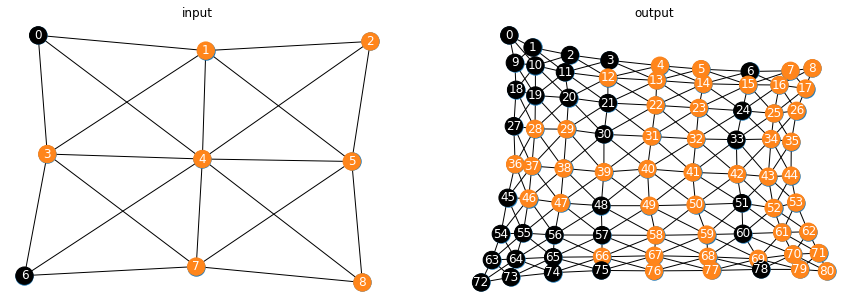

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.box(False)
draw_graph(data_in, "input", axs[0])
draw_graph(data_out, "output", axs[1])

#plt.savefig('this.png')
plt.show()

# Drawing Merged input/output Graph

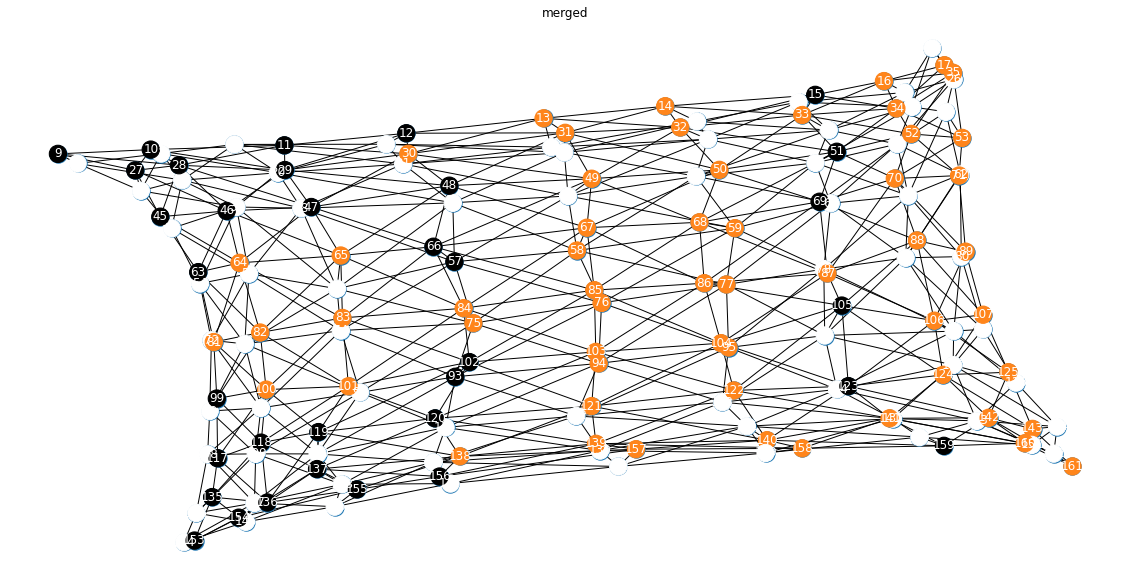

In [248]:
data_merged = sample_to_graph_merged(task['train'][0]["input"], task['train'][0]["output"])

#fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.figure(figsize=(20,10)) 
plt.box(False)
draw_graph(data_merged, "merged")
plt.show()

# Arc Graph Dataset

In [10]:
import os.path as osp
import torch
from torch_geometric.data import Dataset, Batch
import torch_geometric
from torch._six import container_abcs, string_classes, int_classes


class ARCGeometricDataset(Dataset):
    """
    ARC Geometric Dataset loads all ARC tasks in memory and builds a Geometric Batch aggregated graph
    for each task.
    Each element of the dataset is tuple of a Geometric Batch of all train samples in task and original images.
    
    Default class for padding of graph is 11 (10 + 1)
    """
    def __init__(self, arc_path: str, root, mode: str = "train", transform=None, pre_transform=None,
                 pad_value=10, merging: bool = False):
        self.arc_path = Path(arc_path)
        self.mode = mode
        self.task_files = [self.arc_path / f for f in sorted(os.listdir(arc_path))]
        self.tasks = [task_file.stem for task_file in self.task_files]
        self.graph_files = [Path(root) / f"{task}.pt" for task in self.tasks]
        self.pad_value = pad_value
        self.merging = merging
        super(ARCGeometricDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.tasks

    @property
    def processed_file_names(self):
        return self.graph_files

    @property
    def raw_dir(self):
        return  self.arc_path    
    
    @property
    def processed_dir(self):
        return osp.join(self.root, 'processed')
    
    @property
    def num_node_features(self):
        r"""Returns the number of features per node in the dataset."""
        return self[0][0].num_node_features    
    #def download(self):
        # Download to `self.raw_dir`.

        
    def process(self):
        batches = []
        batches_out = []
        batches_pad = []
        batches_out_pad = []
        originals = []
        batches_merged = []
        batches_merged_out = []
        nb = 0
        for (task, task_file, graph_file) in zip(self.tasks, self.task_files, self.graph_files):
            with open(task_file, 'r') as f:
                data_batch = []
                data_batch_out = []
                data_batch_pad = []
                data_batch_out_pad = []
                img_batch = []
                task = json.load(f)
                for t in task["train"]:
                    img_batch.append(t)
                    data = sample_to_graph(t["input"])
                    data_out = sample_to_graph(t["output"])
                    data_batch_out.append(data_out)
                    
                    # pad input to output
                    data_pad = sample_to_graph_padded(t["input"], t["output"], pad_value = self.pad_value)
                    # pad output to input to be sure to have same size at the end
                    data_out_pad = sample_to_graph_padded(t["output"], t["input"], pad_value = self.pad_value)
                    #data_pad.y = data_out_pad
                    data_batch_out_pad.append(data_out_pad)

                    data_batch.append(data)
                    data_batch_pad.append(data_pad)

                batch = Batch.from_data_list(data_batch, follow_batch = [])
                batches.append(batch)

                batch_out = Batch.from_data_list(data_batch_out, follow_batch = [])
                batches_out.append(batch_out)

                batch_pad = Batch.from_data_list(data_batch_pad, follow_batch = [])
                batches_pad.append(batch_pad)

                batch_out_pad = Batch.from_data_list(data_batch_out_pad, follow_batch = [])
                batches_out_pad.append(batch_out_pad)
                
                originals.append(img_batch)
                
                if self.merging:
                    # Create merged input + output graphs
                    # for each index, replace the output by empty output to force it to learn generating them
                    # concatenated in a batch
                    data_merged = []
                    data_merged_out = []
                    for i in range(len(task["train"])):
                        for idx, t in enumerate(task["train"]):
                            merged = sample_to_graph_merged(t["input"], t["output"],
                                                             empty_target=False,
                                                             pad_value = self.pad_value)
                            data_merged_out.append(merged)
                            
                            if i != idx:
                                data_merged.append(merged)
                            else:
                                merged = sample_to_graph_merged(t["input"], t["output"],
                                                                 empty_target=True,
                                                                 pad_value = self.pad_value)
                                data_merged.append(merged)
                                
                    data_merged = Batch.from_data_list(data_merged, follow_batch = [])
                    data_merged_out = Batch.from_data_list(data_merged_out, follow_batch = [])
                    batches_merged.append(data_merged)
                    batches_merged_out.append(data_merged_out)

                #torch.save(batch, graph_file)
                nb += 1
        self.batches = batches
        self.batches_out = batches_out
        
        self.batches_pad = batches_pad
        self.batches_out_pad = batches_out_pad
        
        self.batches_merged = batches_merged
        self.batches_merged_out = batches_merged_out
        
        self.originals = originals

        print(f"Read {nb} files")
 
    def len(self):
        return len(self.batches)

    def get(self, idx):
        if not self.merging:
            return (self.batches[idx], self.batches_out[idx],
                    self.batches_pad[idx], self.batches_out_pad[idx],
                    self.originals[idx])
        else:
            return (self.batches[idx], self.batches_out[idx],
                    self.batches_pad[idx], self.batches_out_pad[idx],
                    self.batches_merged[idx], self.batches_merged_out[idx],
                    self.originals[idx])

        

In [299]:
ds = ARCGeometricDataset(training_path, "./geometric", pad_value=10, merging=True)

Processing...
Read 400 files
Done!


## Sample 1: Input and output matrix have same size


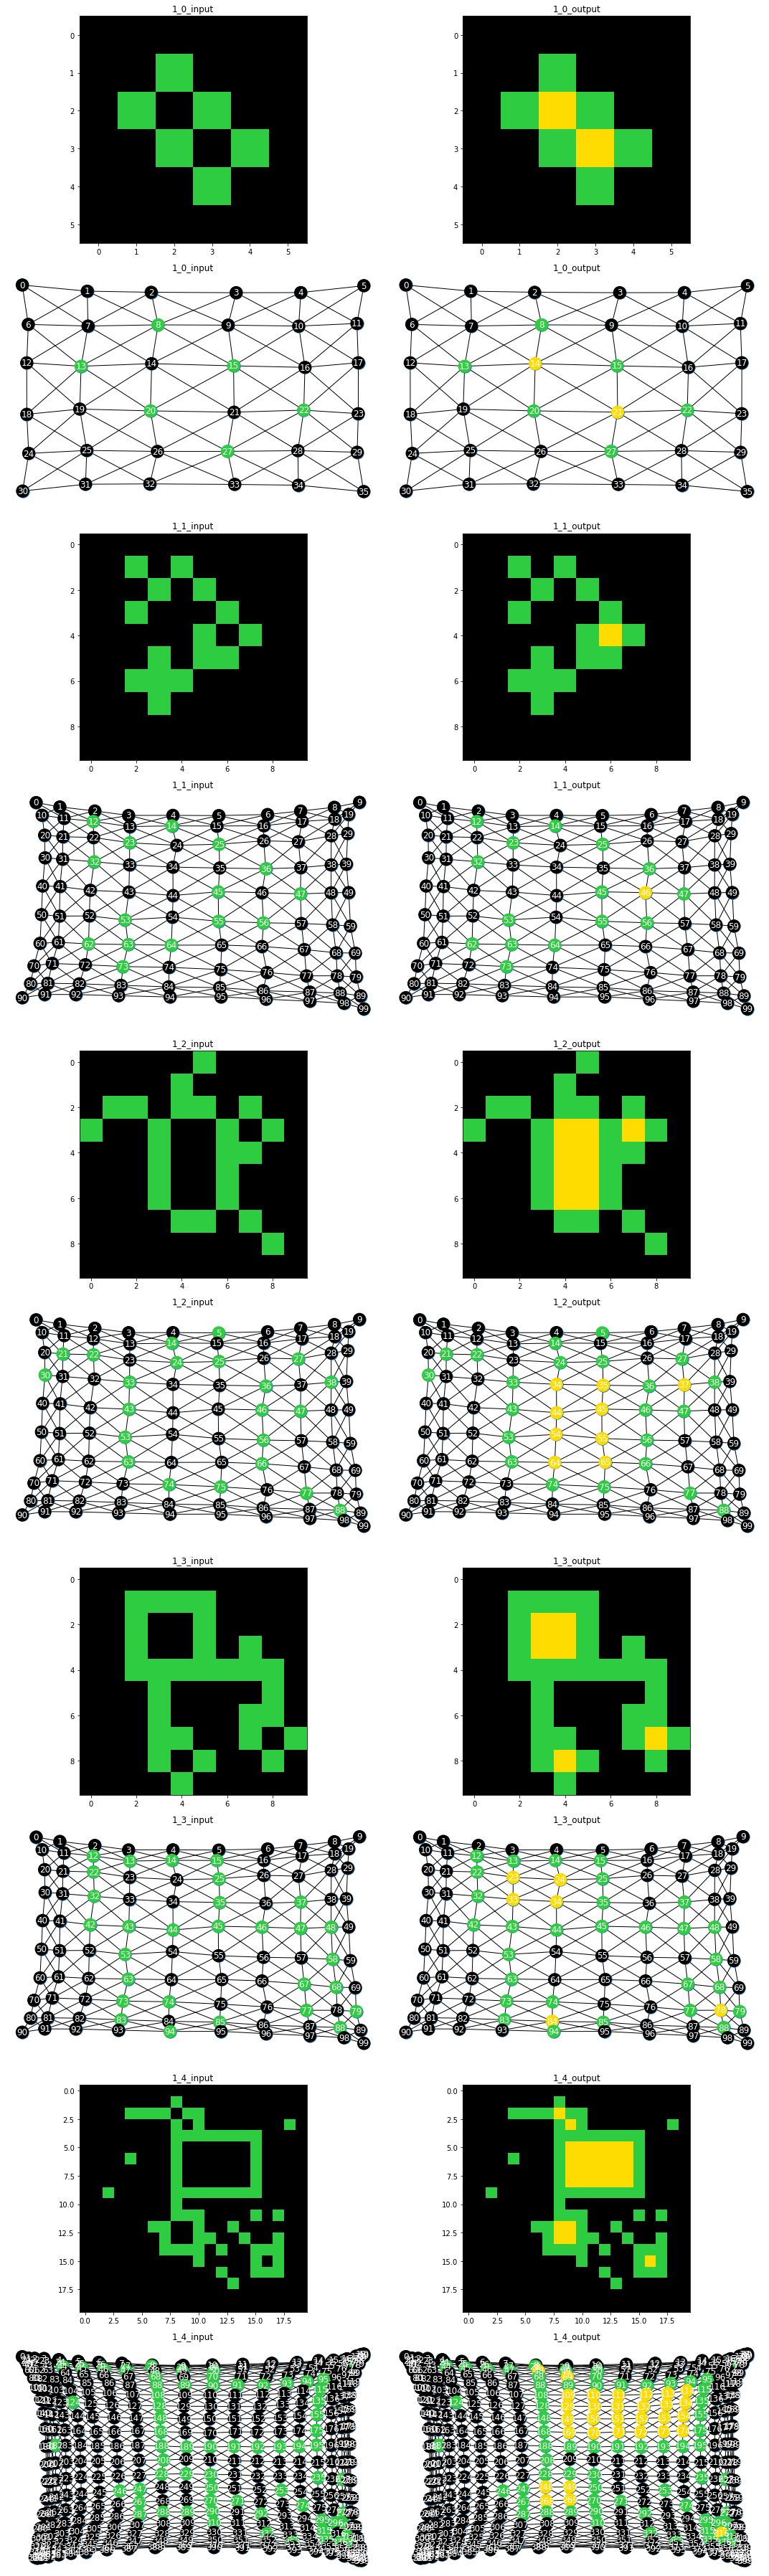

In [34]:
draw_batch_images(ds[1], "1", use_pad=True)

## Sample 2: output matrix is bigger than input matrix

> White node in input graph are padded node to make it same size as output graph
> This is artificial and we could position original graph anywhere but it's easier
> to test GraphNN since generating new nodes is quite hard with GraphNN out-of-the-box


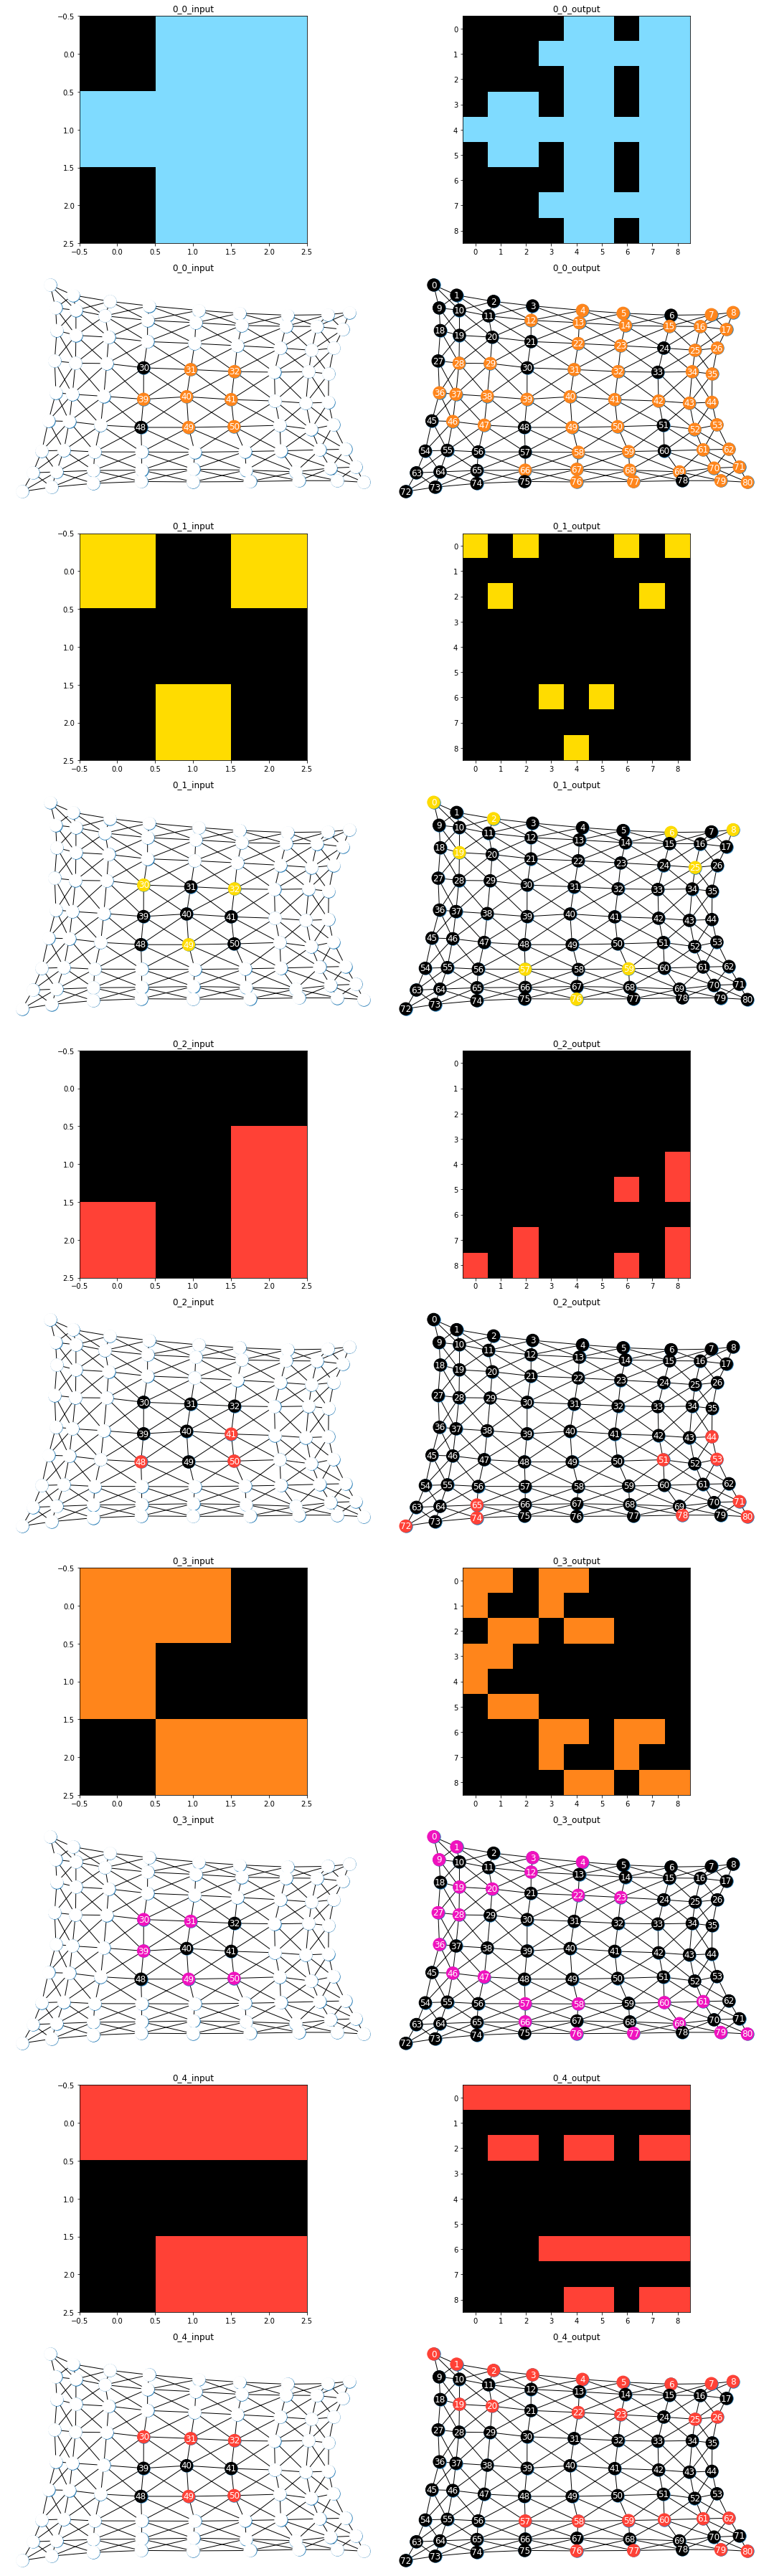

In [17]:
draw_batch_images(ds[0], "0", use_pad=True)

## Sample 3: Output is a vector when input is a matrix

> White node in input graph are padded node to make it same size as output graph
> This is artificial and we could position original graph anywhere but it's easier
> to test GraphNN since generating new nodes is quite hard with GraphNN out-of-the-box


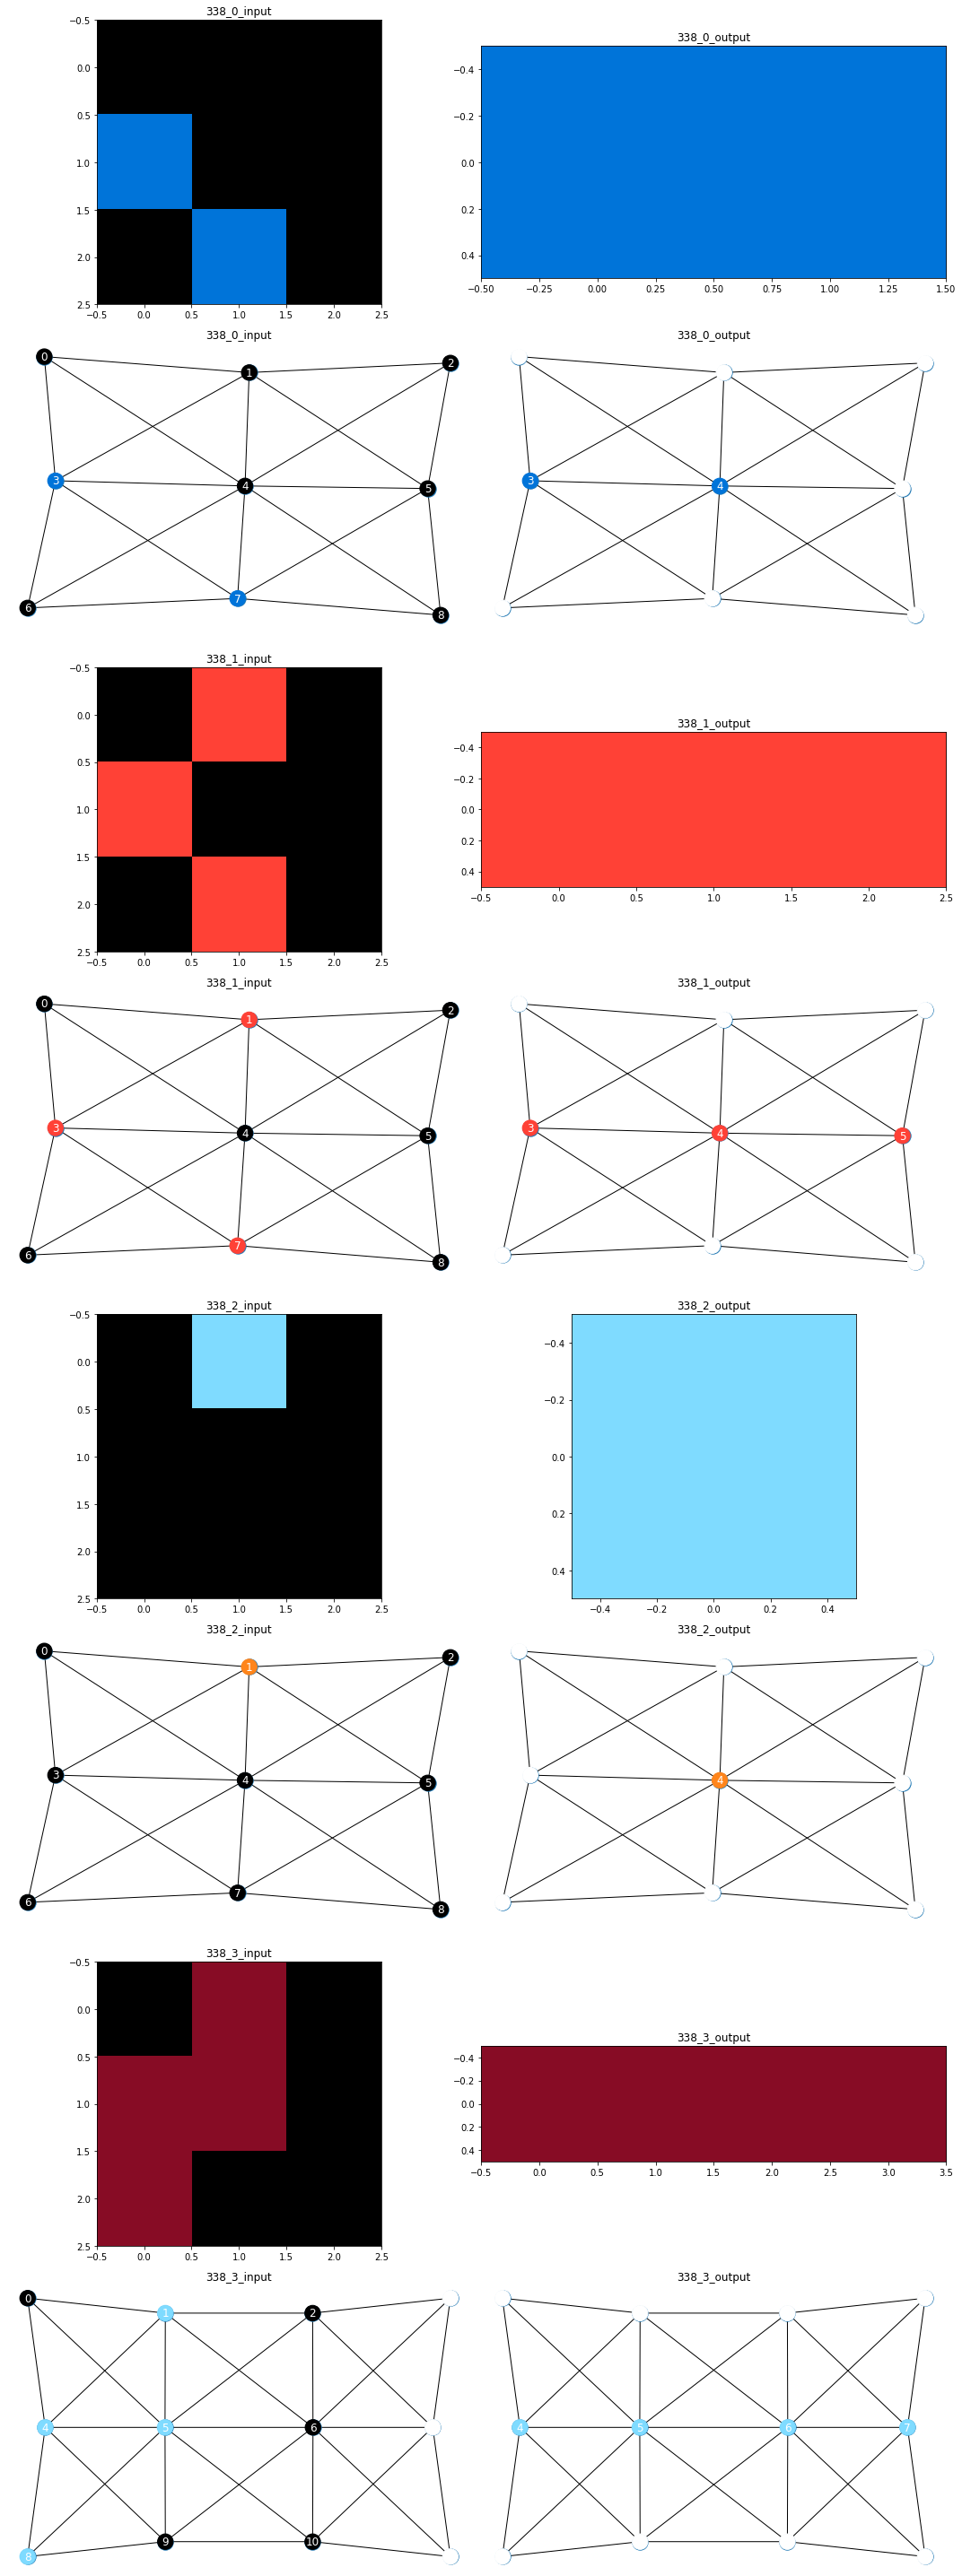

In [17]:
draw_batch_images(ds[338], "338", use_pad=True)

# Training

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pytorch_lightning as pl
from pytorch_lightning import Trainer

class Net(pl.LightningModule):
    def __init__(self, use_pad: bool = True, merging: bool = True, num_node_features: int = 1, data_path = Path('kaggle/input/abstraction-and-reasoning-challenge/')):
        super(Net, self).__init__()
        
        self.training_path = data_path / 'training'
        self.evaluation_path = data_path / 'evaluation'
        self.test_path = data_path / 'test'

        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 11)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.use_pad = use_pad
        self.merging = merging

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def training_step(self, batch, batch_idx):
        data_batches = []
        images = []
        if not self.merging:
            if self.use_pad:
                _, _, data_batch, data_target, _ = batch
            else:
                data_batch, data_target, _, _, _ = batch
        else:
            _, _, _, _, data_batch, data_target, _ = batch
        out = []
        for db in data_batch:
            out.append(self(db))
        out = torch.cat(out, dim=0)
        loss = self.loss_fn(out, data_target)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        data_batches = []
        images = []
        if not self.merging:
            if self.use_pad:
                _, _, data_batch, data_target, images = batch
            else:
                data_batch, data_target, _, _, images = batch
        else:
            _, _, _, _, data_batch, data_target, images = batch
        out = []
        for db in data_batch:
            out.append(self(db))
        out = torch.cat(out, dim=0)
        loss = self.loss_fn(out, data_target)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
        
    def train_dataloader(self):
        ds = ARCGeometricDataset(self.training_path, "./geometric", merging=self.merging, pad_value=10)
        
        train_dataloader = ARCDataLoader(ds, batch_size=1, shuffle=True, num_workers=5, merging=self.merging)
        return train_dataloader

    def val_dataloader(self):
        ds = ARCGeometricDataset(self.evaluation_path, "./geometric", merging=self.merging, pad_value=10)
        
        val_dataloader = ARCDataLoader(ds, batch_size=1, shuffle=False, num_workers=5, merging=self.merging)
        return val_dataloader


In [19]:

        
# Customized        
class ARCCollater(object):
    def __init__(self, follow_batch, merging: bool = False):
        self.follow_batch = follow_batch
        self.merging = merging

    def collate(self, batch):
        #res = []
        batches_out = []
        batches_out_pad = []
        batches = []
        batches_pad = []
        batches_merged = []
        batches_merged_out = []
        images = []
        for e in batch:
            if not self.merging:
                batch_data, batch_out_data, batch_pad, batch_out_pad, imgs = e
            else:
                batch_data, batch_out_data, batch_pad, batch_out_pad, batch_merged, batch_merged_out, imgs = e
                batches_merged.append(batch_merged)
                batches_merged_out.append(batch_merged_out.x)
            batches.append(batch_data)
            batches_pad.append(batch_pad)
            batches_out.append(batch_out_data.x)
            batches_out_pad.append(batch_out_pad.x)
            images.append(imgs)

        batches_out = torch.cat(batches_out, dim=0).long().squeeze()
        batches_out_pad = torch.cat(batches_out_pad, dim=0).long().squeeze()
            
        if not self.merging:
            return (batches, batches_out, batches_pad, batches_out_pad, images)
        else:
            batches_merged_out = torch.cat(batches_merged_out, dim=0).long().squeeze()
            return (batches, batches_out, batches_pad, batches_out_pad, batches_merged, batches_merged_out, images)

    def __call__(self, batch):
        return self.collate(batch)


class ARCDataLoader(torch.utils.data.DataLoader):
    r"""Data loader which merges data objects from a
    :class:`torch_geometric.data.dataset` to a mini-batch.
    Args:
        dataset (Dataset): The dataset from which to load the data.
        batch_size (int, optional): How many samples per batch to load.
            (default: :obj:`1`)
        shuffle (bool, optional): If set to :obj:`True`, the data will be
            reshuffled at every epoch. (default: :obj:`False`)
        follow_batch (list or tuple, optional): Creates assignment batch
            vectors for each key in the list. (default: :obj:`[]`)
    """

    def __init__(self, dataset, batch_size=1, shuffle=False, follow_batch=[], merging: bool = True,
                 **kwargs):
        super(ARCDataLoader,
              self).__init__(dataset, batch_size, shuffle,
                             collate_fn=ARCCollater(follow_batch, merging), **kwargs)

In [21]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device", device)

model = Net(merging=True)

exp = "arc_geometric_v1"
logger = TensorBoardLogger("tb_logs", name=exp)

# DEFAULTS used by the Trainer
checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoints",
    save_top_k=True,
    verbose=False,
    monitor='val_loss',
    mode='min',
    prefix=exp + "_"
)

trainer = Trainer(max_epochs=100, logger=logger, pin_memory=True,
                  distributed_backend=None, checkpoint_callback=checkpoint_callback)

GPU available: True, used: False
No environment variable for node rank defined. Set as 0.


device cuda


In [22]:
trainer.fit(model)


  | Name    | Type             | Params
-----------------------------------------
0 | conv1   | GCNConv          | 32    
1 | conv2   | GCNConv          | 187   
2 | loss_fn | CrossEntropyLoss | 0     


Processing...
Read 400 files
Done!


Processing...
Read 400 files
Done!
Processing...
Read 400 files
Done!


1

In [60]:
best_model = Net.load_from_checkpoint(checkpoint_path="./checkpoints/arc_geometric_v1_epoch=99.ckpt")
best_model.freeze()
best_model

Net(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 11)
  (loss_fn): CrossEntropyLoss()
)

In [61]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000888888888|00000800080808|...
00dbd492_0  |00000000000222220000|02222222220200020000|020...
03560426_0  |0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002220...

In [25]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [67]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    print("reading file", f)
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    # skipping over the training examples, since this will be naive predictions
    # we will use the test input grid as the base, and make some modifications
    # print("task", task)
    data = task['test'][pair_id]['input'] # test pair input
    
    data_merged = []
    output_size = 0
    task_test = task['test'][pair_id] # test task
    test_height_input = len(task_test["input"])
    test_width_input = len(task_test["input"][0])
    min_height_diff = 1e20
    ref_output = None
    ref_output_height = None
    ref_output_width = None
    ref_output_max = None
    ref_output_rate = None
    ref_rate_diff = 1e10
    for idx, t in enumerate(task["train"]):
        t_height_input = len(t["input"])
        t_width_input = len(t["input"][0])
        t_height_output = len(t["output"])
        t_width_output = len(t["output"][0])
        # engineering output size here ;)
        if test_height_input == t_height_input and test_width_input == t_width_input:
            ref_output = t["output"]
        elif test_height_input == t_height_input:
            ref_output_height = t["output"]
        elif test_width_input == t_width_input:
            ref_output_width = t["output"]
        else:
            r = t_height_input / t_width_input - test_height_input / test_width_input
            if r < ref_rate_diff:
                ref_rate_diff = r
                ref_output_rate = t["output"]
        
        merged = sample_to_graph_merged(t["input"], t["output"],
                                        empty_target=False,
                                        pad_value = 10)
        data_merged.append(merged)

    ref_output = ref_output or ref_output_height or ref_output_width or ref_output_rate
    ref_height_output = len(ref_output)
    ref_width_output = len(ref_output[0])
    test_merged = sample_to_graph_merged(task_test["input"], ref_output,
                                    empty_target=True,
                                    pad_value = 10)
    data_merged.append(test_merged)
    
    batch = Batch.from_data_list(data_merged)
    
    #print("batch", batch)
    output = best_model(batch)
    #print("output", output)
    output = torch.nn.functional.softmax(output)
    #print("output", output)
    output = torch.argmax(output, dim=1)
    output = output[:-ref_height_output * -ref_width_output]
    output = output.view(ref_height_output, ref_width_output)
    output = output.cpu().numpy().tolist()
    pred_1 = flattener(output)
    pred = pred_1
    submission.loc[output_id, 'output'] = pred
    #graph = sample_to_graph(data)
    # for the first guess, predict that output is unchanged
    #pred_1 = flattener(data)
    # for the second guess, change all 0s to 5s
    #data = [[5 if i==0 else i for i in j] for j in data]
    #pred_2 = flattener(data)
    # for the last gues, change everything to 0
    #data = [[0 for i in j] for j in data]
    #pred_3 = flattener(data)
    # concatenate and add to the submission output
    #pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    #submission.loc[output_id, 'output'] = pred
print(submission)
submission.to_csv('submission.csv')

reading file kaggle/input/abstraction-and-reasoning-challenge/test/00576224.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/009d5c81.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/00dbd492.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/03560426.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/05a7bcf2.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0607ce86.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0692e18c.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/070dd51e.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/08573cc6.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0934a4d8.json


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


reading file kaggle/input/abstraction-and-reasoning-challenge/test/09c534e7.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0a1d4ef5.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0a2355a6.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0b17323b.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0bb8deee.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0becf7df.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0c786b71.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0c9aba6e.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0d87d2a6.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0e671a1a.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/0f63c0b9.json
reading file kaggle/input/abstraction-and-reasoning-challenge/test/103eff5b.json
reading file kaggle/input/ab